# Russian Stores' Sales Data 


In [54]:
#import useful python modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import ttest_ind
from pandas.tseries import converter
import seaborn as sns
converter.register()
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 18})

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  


## Data Discription

The following csv files consist of sales data, items sold, and item categories from stores in Russia. 

The purpose of exploring this data set is to find attributes that may affect the total sales of items and stores. The attributes I will focus on during this data explortation are the following:

- Seasonality: Are there certain times throughout the year where store/item sales are higher than normal  
- Shop Sales (in regards to category sales): i.e., certain stores may sell more of an item category when compared to other stores
- Store unique item count: The more unique items a store sales, the higher the store's revenue 
- Item price: The more the price varies from it's mean, the less units it will sell 
- Item category: When comparing categories, the higher the total sales, the more item units sold 

### File descriptions

sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

items.csv - supplemental information about the items/products.

### Data fields

ID - an Id that represents a (Shop, Item) tuple within the test set

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_category_id - unique identifier of item category

item_cnt_day - number of products sold

item_price - current price of an item

date - date in format dd/mm/yyyy

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 
2015 is 33

item_name - name of item

#### Import and Clean Data

In [92]:
#import csv files into dataframes
sales_train=pd.read_csv('sales_train.csv')
items=pd.read_csv('items.csv')

#merge sales_train and items dfs into one dataframe - sales_df
sales_df=pd.merge(sales_train, items, how='inner', on='item_id')

#change values in date column from str to timestamp 
#new format - yyyy/mm/dd
sales_df['date']=pd.to_datetime(sales_df['date'],dayfirst=True)

#year and sales (item_cnt_day * price) columns to help with data 
#exploration and vizualization 
date = sales_df['date'].tolist()
year = [x.year for x in date]
sales_df['year'] = year
sales_df['sales'] = sales_df.item_price*sales_df.item_cnt_day
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,year,sales
0,2013-01-02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,2013,999.0
1,2013-01-23,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,2013,999.0
2,2013-01-20,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,2013,999.0
3,2013-01-02,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,2013,999.0
4,2013-01-03,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,2013,999.0


#### Description of Dataset: 
After reviewing the description of the data set, we can conclude that there are no Null-N/a values, since each count of the column are equal to each other. I also verified this by using the .isnull() function. Each column (excluding the year column) has a large standard deviation, especially columns 'item_price' and 'item_id'. High standard deviation may signal noise in the data, but we will look more into this later on. To reduce the noise within the dataset before moving forward, we will remove the negative values in item_price and item_cnt_day, as we know an item cannot have a 'negative price' nor a 'negative sale'. 

In [93]:
print(sales_df[['item_price','item_cnt_day','sales']].describe())
sales_df.isnull().values.any()

         item_price  item_cnt_day         sales
count  2.935849e+06  2.935849e+06  2.935849e+06
mean   8.908532e+02  1.242641e+00  1.157732e+03
std    1.729800e+03  2.618834e+00  5.683604e+03
min   -1.000000e+00 -2.200000e+01 -6.897000e+04
25%    2.490000e+02  1.000000e+00  2.490000e+02
50%    3.990000e+02  1.000000e+00  4.490000e+02
75%    9.990000e+02  1.000000e+00  1.078200e+03
max    3.079800e+05  2.169000e+03  1.829990e+06


False

In [94]:
#remove negative values within 'item_price' and 'item_cnt_day' columns
sales_df = sales_df[sales_df.item_price >= 0]
sales_df = sales_df[sales_df.item_cnt_day >= 0]

## Noise 

Prior to analyzing attributes to see if they have an affect on sales, I will look into the following to see if they introduce noise into the data: 

- Sales by year
- Sales by store 
- Sales by category 

#### Sales by year

At first glance, it looks like years 2014 and 2013 are compatible, but year 2015 is not. However, after looking deeper into the dataset, we will find that we do not have the complete dataset for year 2015. In order to avoid potentially adding noise into our dataset, I will only look at data from year 2014, since it's the highest performing year.  

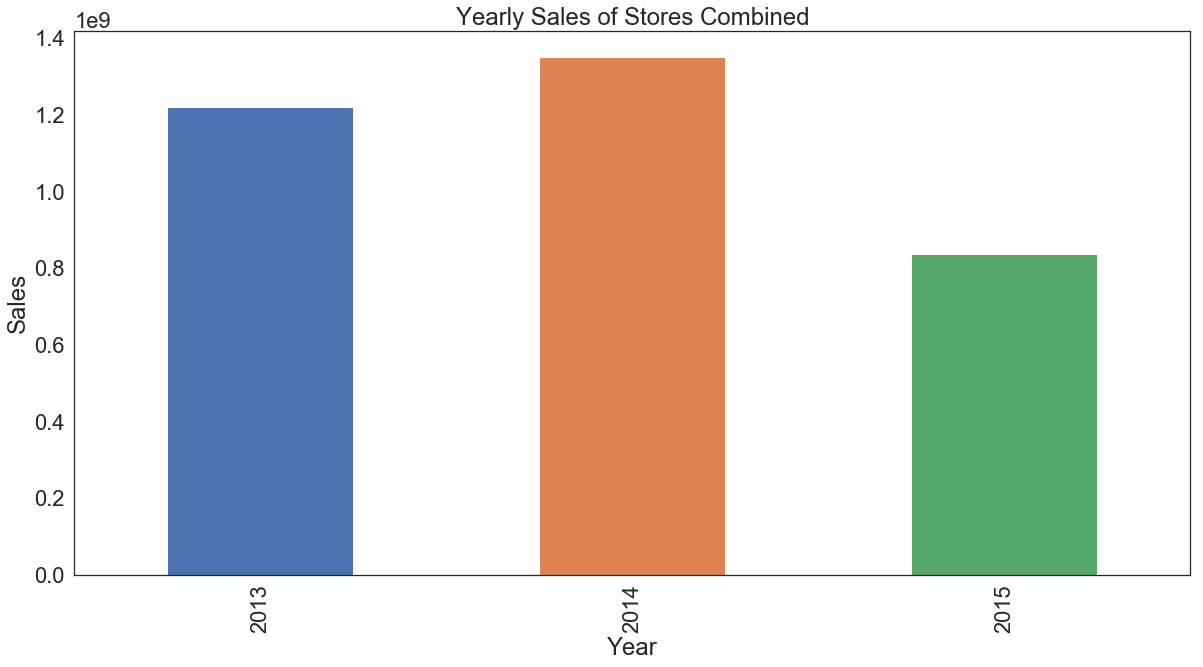

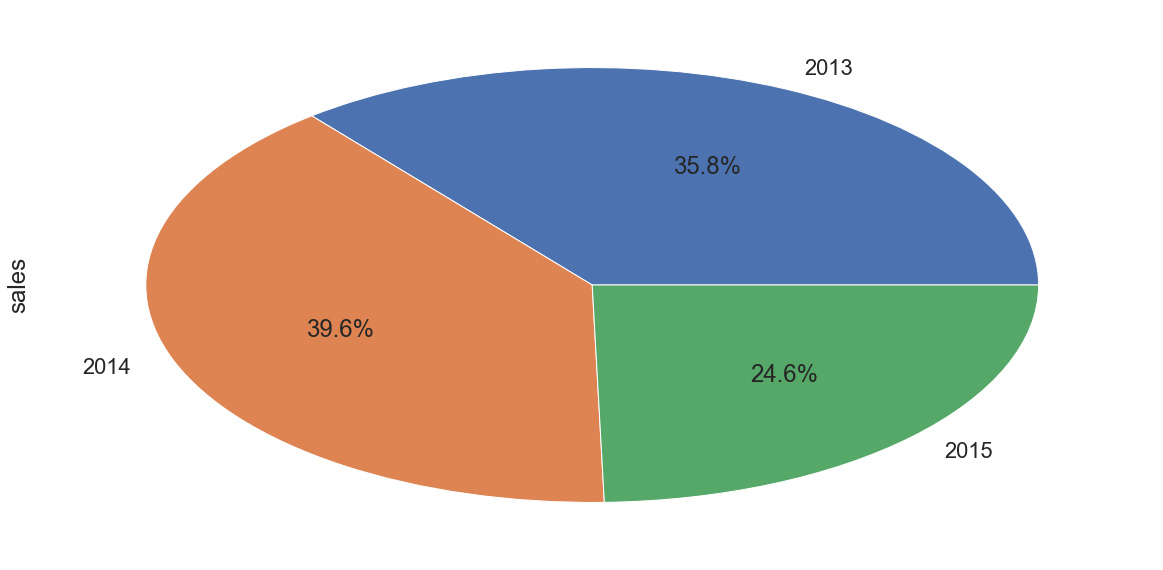

In [95]:
#create a bar chart of total sales by year  
sales_df.groupby('year')['sales'].sum().plot(kind='bar')
plt.title('Yearly Sales of Stores Combined')
plt.ylabel('Sales')
plt.xlabel('Year')
plt.show()
sales_df.groupby('year')['sales'].sum().plot(kind='pie', autopct='%1.1f%%')
plt.show()

In [96]:
#remove years 2013 and 2015 data from dataframe
sales_df = sales_df[sales_df.year == 2014]
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,year,sales
66,2014-06-28,17,28,2552,949.0,1.0,DEEP PURPLE The House Of Blue Light LP,58,2014,949.0
114,2014-01-19,12,42,2555,1149.0,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2014,1149.0
115,2014-02-11,13,31,2555,1149.0,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2014,1149.0
116,2014-02-10,13,19,2555,1149.0,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2014,1149.0
117,2014-02-22,13,50,2555,1149.0,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2014,1149.0


#### Sales by store

After reviewing the histogram, boxplot and data description of the store sales, you can see that there are outliers within the dataset, which will introduce noise. In order to furthur remove noise from the dataset, we will only use stores who had yearly sales between '15,000,000 dollars' and 
'29,000,000 dollars'. We will compare store counts prior to and after removing outliers to see if it makes a signficant difference 

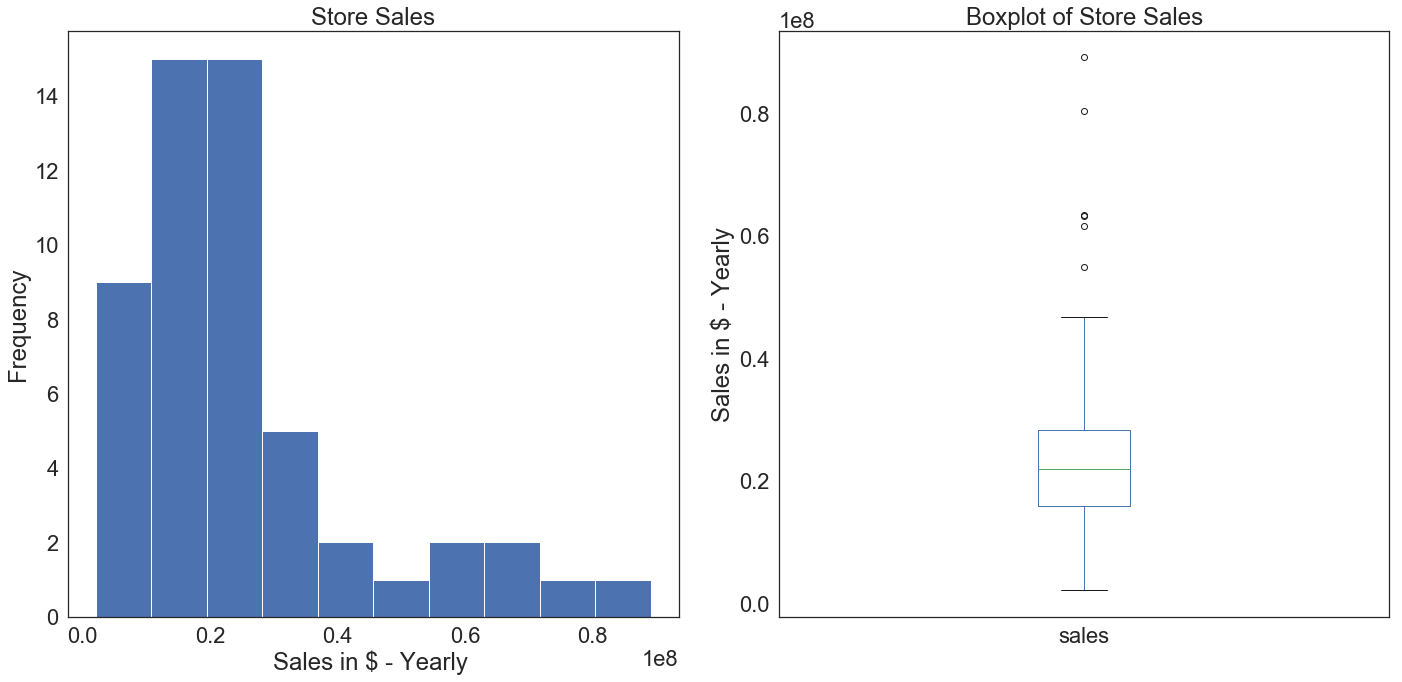

count    5.300000e+01
mean     2.549105e+07
std      1.874081e+07
min      2.128062e+06
25%      1.584417e+07
50%      2.189779e+07
75%      2.824744e+07
max      8.914861e+07
Name: sales, dtype: float64

In [97]:
#histogram and boxplot of store sum of sales in 2014 
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sales_df.groupby('shop_id')['sales'].sum().plot(kind='hist')
plt.xlabel('Sales in $ - Yearly ')
plt.title('Store Sales')

plt.subplot(1,2,2)
sales_df.groupby('shop_id')['sales'].sum().plot(kind='box')
plt.ylabel('Sales in $ - Yearly')
plt.title('Boxplot of Store Sales')
plt.tight_layout()
plt.show()
sales_df.groupby('shop_id')['sales'].sum().describe()

In [98]:
#amount of stores in dataframe prior to removing outliers 
len(sales_df.shop_id.unique())

53

In [99]:
#amount of stores in dataframe after removing outliers 
sales_df.groupby('shop_id').sum().query('15000000 <= sales <= 29000000')['sales'].count()

28

In [100]:
#28 stores are withing new range (over %50), so is noise was significant. 

#setting new dataframe removing store outliers
#first, create a list of stores to keep from querying dataframe
stores_to_keep = list(sales_df.groupby('shop_id').sum().query('15000000 <= sales <= 29000000')['sales'].index)
stores_to_keep

#create new df with only stores that have yearly sales within referenced range
sales_df = sales_df[sales_df.shop_id.isin(stores_to_keep)]

#### Sales by category

Similar to sales by store, you can see that there are outliers within the dataset, which will introduce noise. In order to furthur remove noise from the dataset, we will only use categories who had yearly sales between '490,000 dollars' and 
'10,000,000 dollars'. We will compare category counts prior to and after removing outliers to see if it makes a signficant difference 

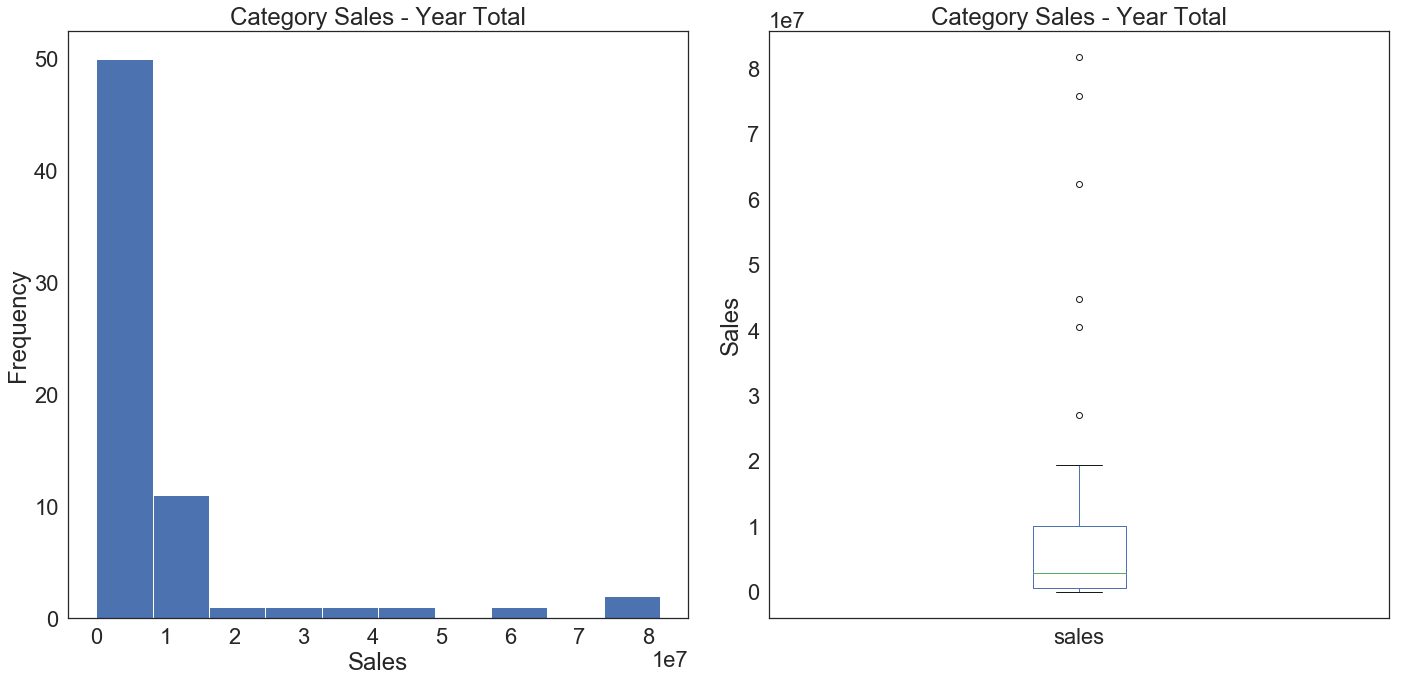

count    6.800000e+01
mean     8.832106e+06
std      1.641254e+07
min      1.290000e+02
25%      4.942800e+05
50%      2.846984e+06
75%      9.984076e+06
max      8.168215e+07
Name: sales, dtype: float64

In [101]:
#histogram and boxplot of category sum of sales in 2014 
plt.subplot(1,2,1)
sales_df.groupby('item_category_id')['sales'].sum().plot(kind='hist')
plt.xlabel('Sales')
plt.title('Category Sales - Year Total')

plt.subplot(1,2,2)
sales_df.groupby('item_category_id')['sales'].sum().plot(kind='box')
plt.ylabel('Sales')
plt.title('Category Sales - Year Total')
plt.tight_layout()
plt.show()
sales_df.groupby('item_category_id')['sales'].sum().describe()

In [102]:
len(sales_df.item_category_id.unique())

68

In [103]:
#amount of stores in dataframe after removing outliers 
sales_df.groupby('item_category_id').sum().query('490000 <= sales <= 10000000')['sales'].count()

34

In [104]:
#34 categories are withing new range (%50), so the noise was significant. 

#setting new dataframe removing store outliers
#first, create a list of categories to keep from querying dataframe
cat_to_keep = list(sales_df.groupby('item_category_id').sum().query('490000 <= sales <= 10000000')['sales'].index)
cat_to_keep

#create new df with only stores that have yearly sales within referenced range
sales_df = sales_df[sales_df.item_category_id.isin(cat_to_keep)]

In [105]:
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,year,sales
116,2014-02-10,13,19,2555,1149.0,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2014,1149.0
117,2014-02-22,13,50,2555,1149.0,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2014,1149.0
119,2014-03-16,14,17,2555,1149.0,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2014,1149.0
3745,2014-10-16,21,17,2548,1799.0,1.0,DEEP PURPLE Stormbringer LP,58,2014,1799.0
3896,2014-11-27,22,14,2515,1999.0,1.0,DEEP PURPLE Come Taste The Band Original Rec...,58,2014,1999.0


Now that we have removed as much noise as possible, let's look into each attribute. 

## Question 1: Seasonality - Does time affect sales? 

To start, let's look at monthly sales of all stores combined.

date_block_num
12     9029668.45
13     8029952.30
14     7982376.73
15     7495870.97
16     6458798.78
17     6663625.99
18     7276602.16
19     7936407.32
20     9612042.78
21    10022099.30
22    11837669.20
23    24974622.88
Name: sales, dtype: float64
count    3.650000e+02
mean     3.214239e+05
std      2.220621e+05
min      1.260216e+05
25%      2.141895e+05
50%      2.592160e+05
75%      3.554937e+05
max      1.999162e+06
Name: sales, dtype: float64


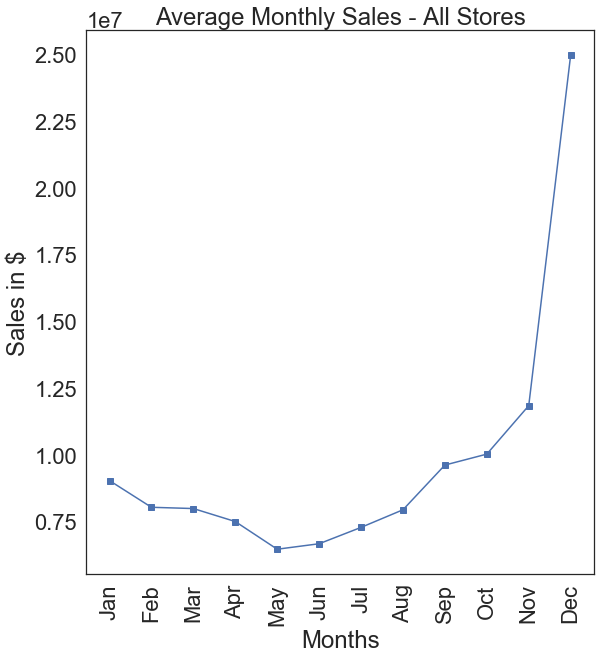

In [106]:
#first let's look at average monthly sales of all stores combined, grouping by the 'date_block_num' 
#where 12 == January and 23 == December

month_labels = ['Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 'Jul',
             'Aug',  'Sep',  'Oct',  'Nov',  'Dec']


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sales_df.groupby('date_block_num')['sales'].sum().plot(style='bs-')
plt.ylabel('Sales in $')
plt.xticks(list(sorted(sales_df.date_block_num.unique())), month_labels, rotation='vertical')
plt.xlabel('Months')
plt.title('Average Monthly Sales - All Stores')

print(sales_df.groupby('date_block_num')['sales'].sum())
print(sales_df.groupby('date')['sales'].sum().describe())

After review, it looks like Sept-Dec. is the 'high season'. Let's create two dataframes, one that contains the data from months within the high season, and another that contains the data from the months within the low season. Afterwards, lets plot the histogram and boxplot of sales for each dataframe, then compare the two using a t-test. 

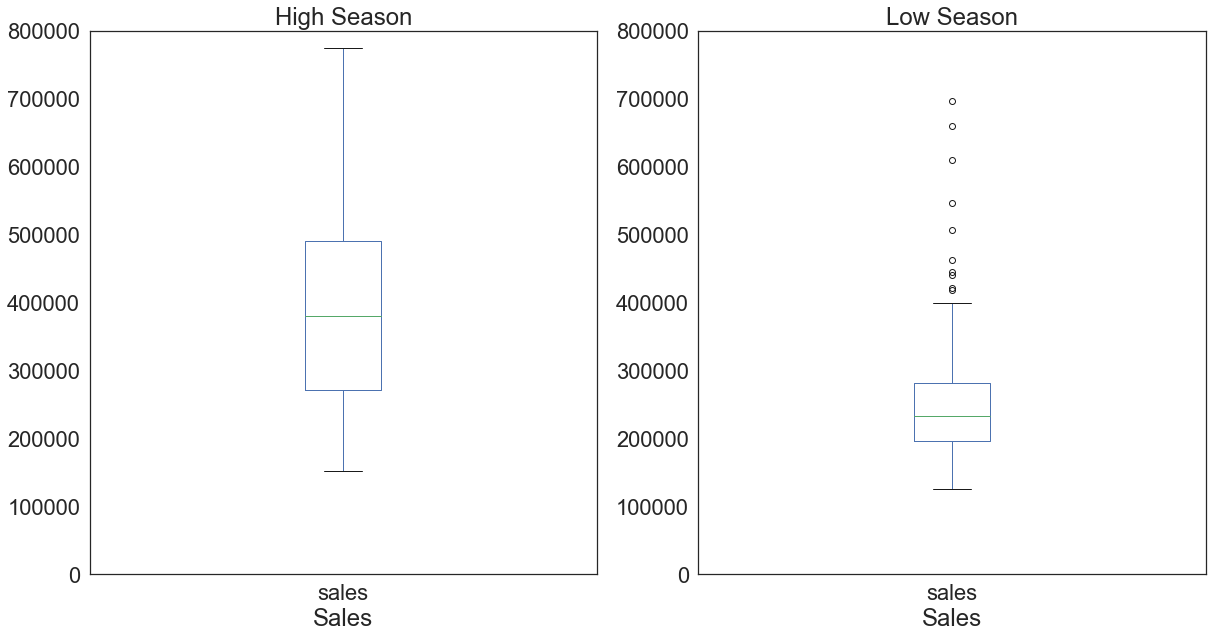

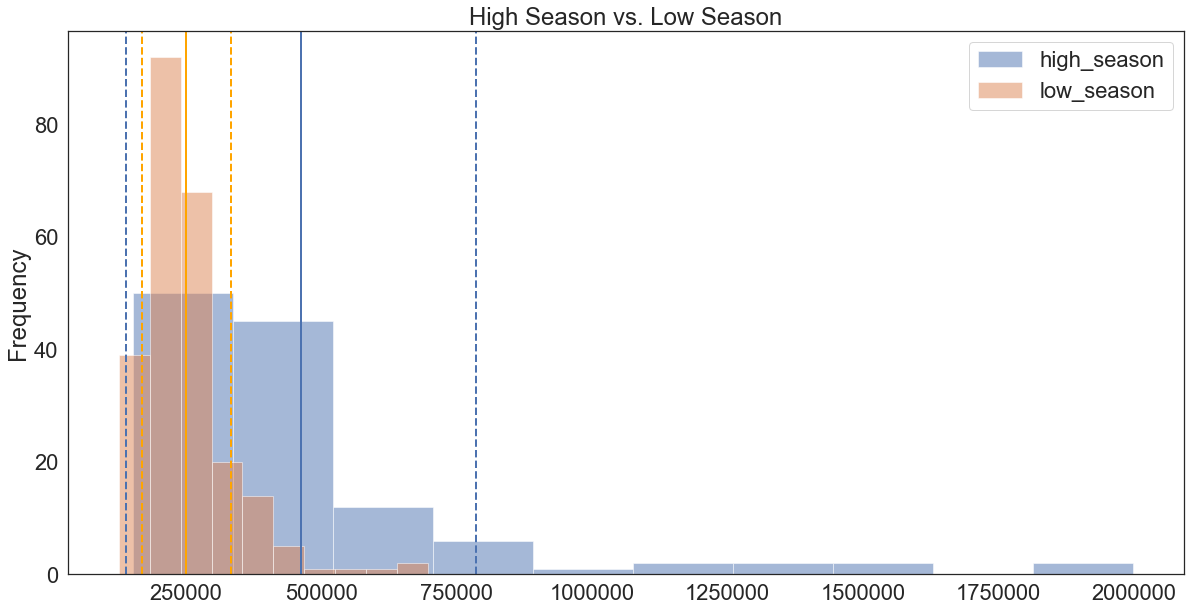

In [107]:
#we will categorize months 20, 21, 22 and 23 (Sept - December) and the rest of the year as low season 

high_season = sales_df[sales_df.date_block_num.isin([20,21,22,23])]
low_season = sales_df[np.logical_not(sales_df.date_block_num.isin([20,21,22,23]))]

#boxplot high season vs. low season 
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
high_season.groupby('date').sum().sales.plot(kind='box')
plt.ylim(0,800000)
plt.xlabel("Sales")
plt.title('High Season')

plt.subplot(1,2,2)
low_season.groupby('date').sum().sales.plot(kind='box')
plt.ylim(0,800000)
plt.xlabel("Sales")
plt.title('Low Season')
plt.show()

#histograms high season vs. low season
plt.figure(figsize=(20,10))
high_season.groupby('date').sum().sales.plot(kind='hist', alpha=0.5, label = 'high_season')
plt.title('High Season')
# Add a vertical line at the mean.
plt.axvline(high_season.groupby('date').sum().sales.mean(), color='b', linestyle='solid', linewidth=2)
# Add a vertical line at one standard deviation above the mean.
plt.axvline(high_season.groupby('date').sum().sales.mean() + high_season.groupby('date').sum().sales.std(), color='b', linestyle='dashed', linewidth=2)
# Add a vertical line at one standard deviation below the mean.
plt.axvline(high_season.groupby('date').sum().sales.mean()-high_season.groupby('date').sum().sales.std(), color='b', linestyle='dashed', linewidth=2)

low_season.groupby('date').sum().sales.plot(kind='hist', alpha=0.5, label = 'low_season')
# Add a vertical line at the mean.
plt.axvline(low_season.groupby('date').sum().sales.mean(), color='orange', linestyle='solid', linewidth=2)
# Add a vertical line at one standard deviation above the mean.
plt.axvline(low_season.groupby('date').sum().sales.mean() + low_season.groupby('date').sum().sales.std(), color='orange', linestyle='dashed', linewidth=2)
# Add a vertical line at one standard deviation below the mean.
plt.axvline(low_season.groupby('date').sum().sales.mean()-low_season.groupby('date').sum().sales.std(), color='orange', linestyle='dashed', linewidth=2)
plt.title('High Season vs. Low Season')
plt.legend(loc='upper right')
plt.show()

In [108]:
print(ttest_ind(high_season.sales, low_season.sales, equal_var=False))

Ttest_indResult(statistic=34.59502587771003, pvalue=2.418157256857739e-260)


### Question 1 Conclusion: 

In conclusion, high season's sales are much higher than low season's sale. To compare the high season and low season, I chose to use the T-test. Although, the distributions between the two variables are different (see histograms), we can still use the T-test because we have enough datapoints. From the t-test, we see that it is a very small probability that these two variables are similar. Therefore, in order to reduce noise while analyzing the attributes, we will use the low season data moving forward. 

In [109]:
#let's us low season sales moving foward in our analysis. 
low_season.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,year,sales
116,2014-02-10,13,19,2555,1149.0,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2014,1149.0
117,2014-02-22,13,50,2555,1149.0,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2014,1149.0
119,2014-03-16,14,17,2555,1149.0,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2014,1149.0
13151,2014-01-11,12,53,2920,599.0,1.0,Disney. LEGO Пираты Карибского моря (Essential...,21,2014,599.0
13153,2014-01-04,12,56,2920,599.0,1.0,Disney. LEGO Пираты Карибского моря (Essential...,21,2014,599.0


## Question 2: Does Shop Sales affect Category Sales? 

To start, let's create a dataframe that consist of store yearly sales and columns of category yearly sales by store.

In [110]:
#create dataframe where index = shop_id and columns = store yearly sales and category yearly sales by store 

#first, create dataframe of store yearly sales 
store_sales = low_season.groupby('shop_id').sum()['sales']
store_sales = store_sales.to_frame()

#add columns for each category to store_sales 
list_of_cat = list(low_season.item_category_id.unique())
list_of_cat.sort()
list_of_cat

for i in list_of_cat:
    store_sales['item_cat_{}_sales'.format(i)] = np.nan    

#create category yearly sales by store dataframe 
cat_by_stores = low_season.groupby(['shop_id','item_category_id']).sum()['sales']
cat_by_stores = cat_by_stores.to_frame()


#add yearly category sales by store to store_sales dataframe
for i in store_sales.index: 
    for j in cat_by_stores.loc[i].index: 
        try:
            store_sales['item_cat_{}_sales'.format(j)].loc[i] = cat_by_stores.loc[i].loc[j].sales
        except:
            store_sales['item_cat_{}_sales'.format(j)] = np.nan
            
store_sales.head(7)

,sales,item_cat_2_sales,item_cat_5_sales,item_cat_6_sales,item_cat_8_sales,item_cat_14_sales,item_cat_21_sales,item_cat_22_sales,item_cat_25_sales,item_cat_32_sales,...,item_cat_62_sales,item_cat_63_sales,item_cat_64_sales,item_cat_65_sales,item_cat_67_sales,item_cat_69_sales,item_cat_70_sales,item_cat_73_sales,item_cat_76_sales,item_cat_79_sales
shop_id,,,,,,,,,,,,,,,,,,,,,
2,1252242.62,210739.1,2089.0,158779.6,NaN,26470.0,58652.4,99674.0,19725.0,16000.0,...,12533.0,80216.0,52563.0,16070.5,63121.0,40578.5,7975.0,46716.0,NaN,14812.0
4,1541442.69,173198.0,33593.0,135334.4,NaN,129464.0,49765.0,99145.0,66418.7,18300.0,...,44943.0,84519.0,61202.0,20038.0,45376.0,32377.0,3223.0,35800.0,NaN,93211.0
5,1619563.68,141109.0,20937.0,118089.2,8300.0,61927.1,45628.3,84543.9,56436.0,16800.0,...,109263.0,125687.7,106882.5,32437.6,117186.3,43188.9,22132.0,39700.0,NaN,27337.0
7,2553608.41,269859.7,33308.0,214852.1,NaN,157310.0,130842.8,205700.0,74759.0,40800.0,...,97175.0,171420.0,122912.0,68016.0,154706.0,70870.0,12776.0,42200.0,NaN,51912.0
14,1413913.30,115096.5,6284.0,131757.2,2000.0,41950.0,31704.0,62866.0,NaN,19000.0,...,29932.0,146663.0,129911.0,88736.0,10771.0,30256.0,20349.0,22200.0,NaN,17120.0
15,2089539.13,176365.7,1590.0,191505.0,7200.0,26970.0,138053.2,144297.0,12411.8,19800.0,...,38912.0,41934.0,69329.0,42667.0,117904.0,45399.0,18806.0,49800.0,NaN,14869.0
16,2602034.10,245885.7,30352.2,200221.3,25300.0,175719.7,95889.9,111470.3,127147.5,28000.0,...,61467.0,124863.7,238198.5,124677.0,123952.0,48336.0,28284.0,157030.0,NaN,11600.0


In [111]:
#remove rows and columns where na values are more than 5
store_sales = store_sales.dropna(axis=0,thresh=5).dropna(axis=1,thresh=5)

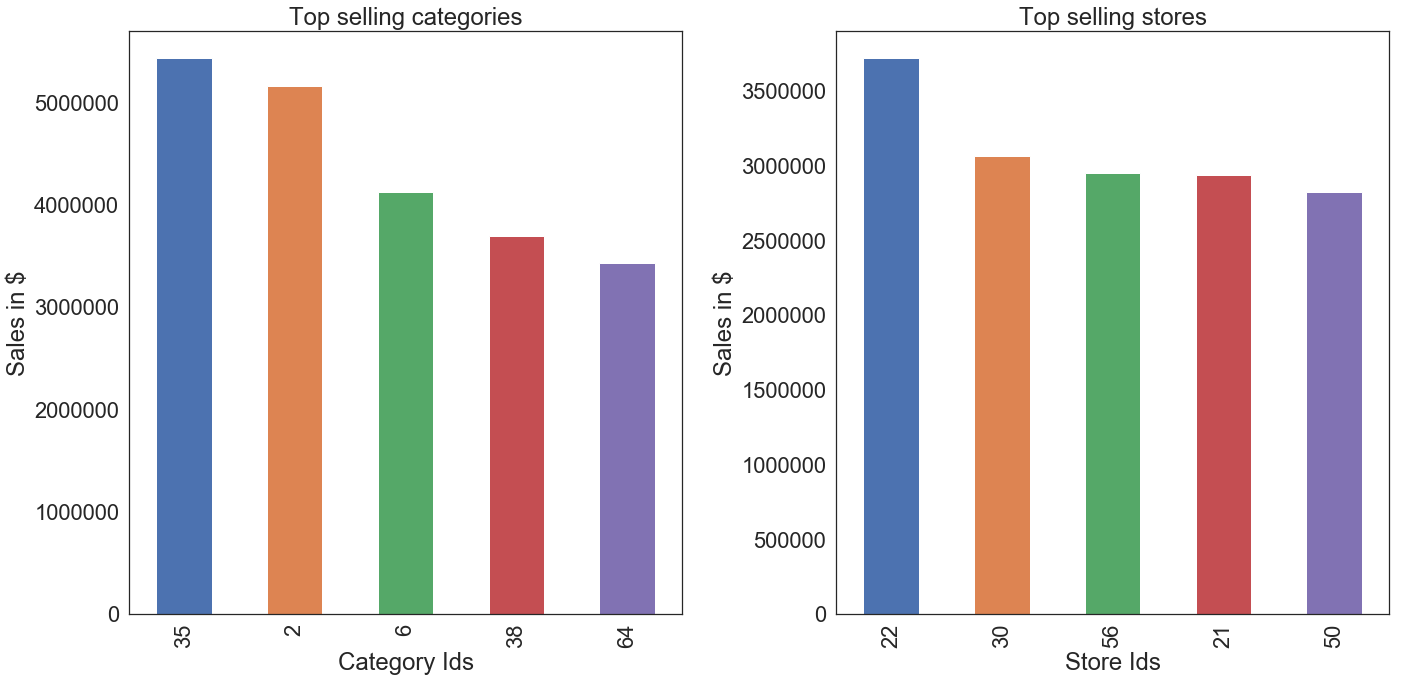

In [112]:
plt.subplot(1,2,1)
#bar chart of top performing categories in regards to sales
low_season.groupby(['item_category_id'])['sales'].sum().sort_values(ascending=False).iloc[:5].plot(kind='bar')
plt.ylabel('Sales in $')
plt.xlabel("Category Ids")
plt.title('Top selling categories')

plt.subplot(1,2,2)
#bar chart of top performing stores in regards to sales 
store_sales.sales.sort_values(ascending=False).iloc[:5].plot(kind='bar')
plt.ylabel('Sales in $')
plt.xlabel("Store Ids")
plt.title('Top selling stores')
plt.tight_layout()
plt.show()

In [113]:
#create a top category column that totals the sales of the top 5 categories by stores
store_sales['top_cat_sum'] = store_sales[['item_cat_2_sales','item_cat_35_sales','item_cat_6_sales',
             'item_cat_38_sales','item_cat_64_sales']].sum(axis=1)
store_sales.head()

,sales,item_cat_2_sales,item_cat_5_sales,item_cat_6_sales,item_cat_8_sales,item_cat_14_sales,item_cat_21_sales,item_cat_22_sales,item_cat_25_sales,item_cat_32_sales,...,item_cat_62_sales,item_cat_63_sales,item_cat_64_sales,item_cat_65_sales,item_cat_67_sales,item_cat_69_sales,item_cat_70_sales,item_cat_73_sales,item_cat_79_sales,top_cat_sum
shop_id,,,,,,,,,,,,,,,,,,,,,
2,1252242.62,210739.1,2089.0,158779.6,NaN,26470.0,58652.4,99674.0,19725.0,16000.0,...,12533.0,80216.0,52563.0,16070.5,63121.0,40578.5,7975.0,46716.0,14812.0,632960.56
4,1541442.69,173198.0,33593.0,135334.4,NaN,129464.0,49765.0,99145.0,66418.7,18300.0,...,44943.0,84519.0,61202.0,20038.0,45376.0,32377.0,3223.0,35800.0,93211.0,632799.51
5,1619563.68,141109.0,20937.0,118089.2,8300.0,61927.1,45628.3,84543.9,56436.0,16800.0,...,109263.0,125687.7,106882.5,32437.6,117186.3,43188.9,22132.0,39700.0,27337.0,614855.06
7,2553608.41,269859.7,33308.0,214852.1,NaN,157310.0,130842.8,205700.0,74759.0,40800.0,...,97175.0,171420.0,122912.0,68016.0,154706.0,70870.0,12776.0,42200.0,51912.0,1010140.21
14,1413913.30,115096.5,6284.0,131757.2,2000.0,41950.0,31704.0,62866.0,NaN,19000.0,...,29932.0,146663.0,129911.0,88736.0,10771.0,30256.0,20349.0,22200.0,17120.0,626264.60


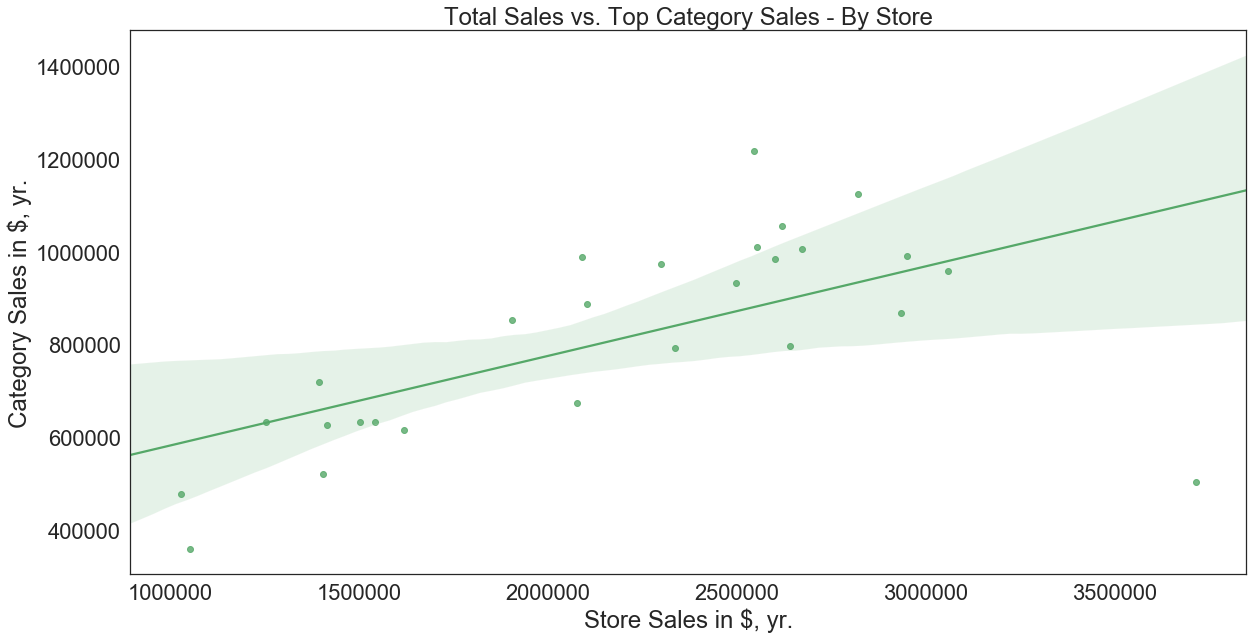

In [114]:
sns.regplot(x='sales',y='top_cat_sum', data=store_sales, color='g')
plt.title('Total Sales vs. Top Category Sales - By Store')
plt.xlabel('Store Sales in $, yr.')
plt.ylabel('Category Sales in $, yr.')
plt.show()

In [115]:
#correlation between store sales and the sum of sales for the top 5 categories
print(np.corrcoef(x=store_sales.sales,y=store_sales.top_cat_sum))

[[1.         0.60805363]
 [0.60805363 1.        ]]


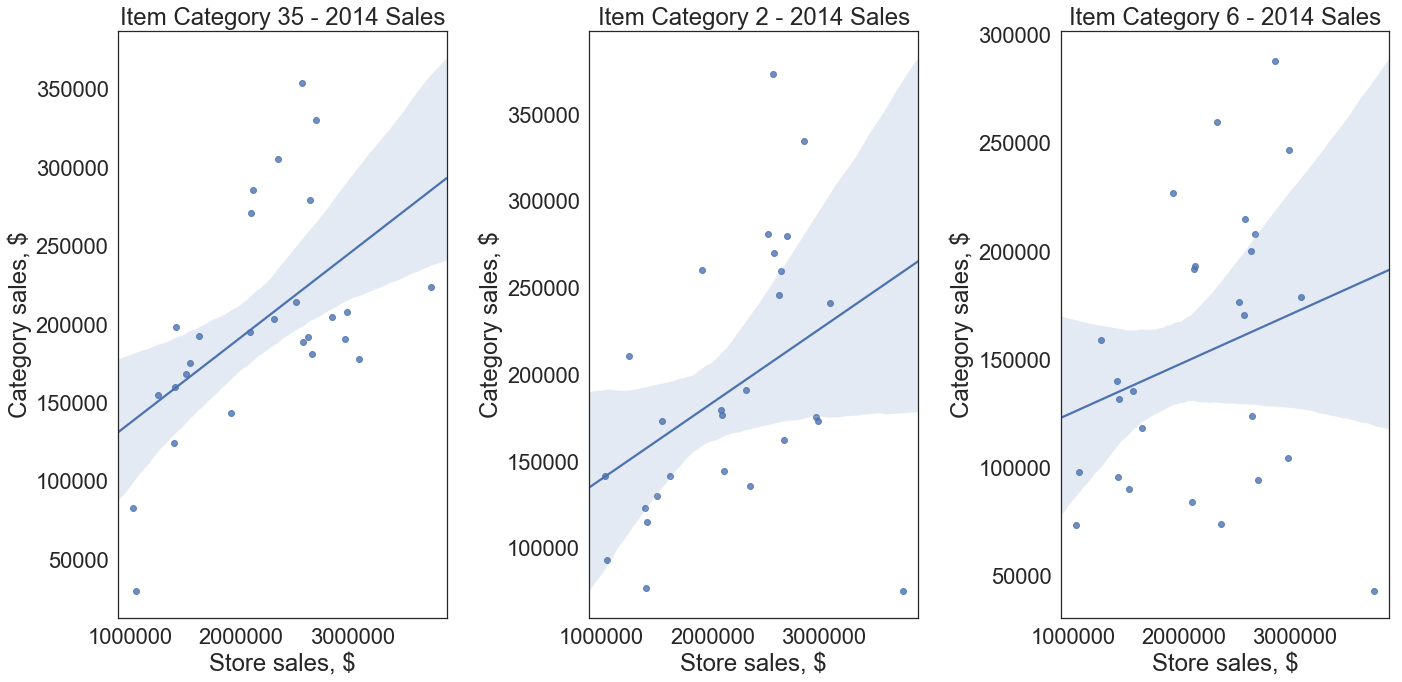

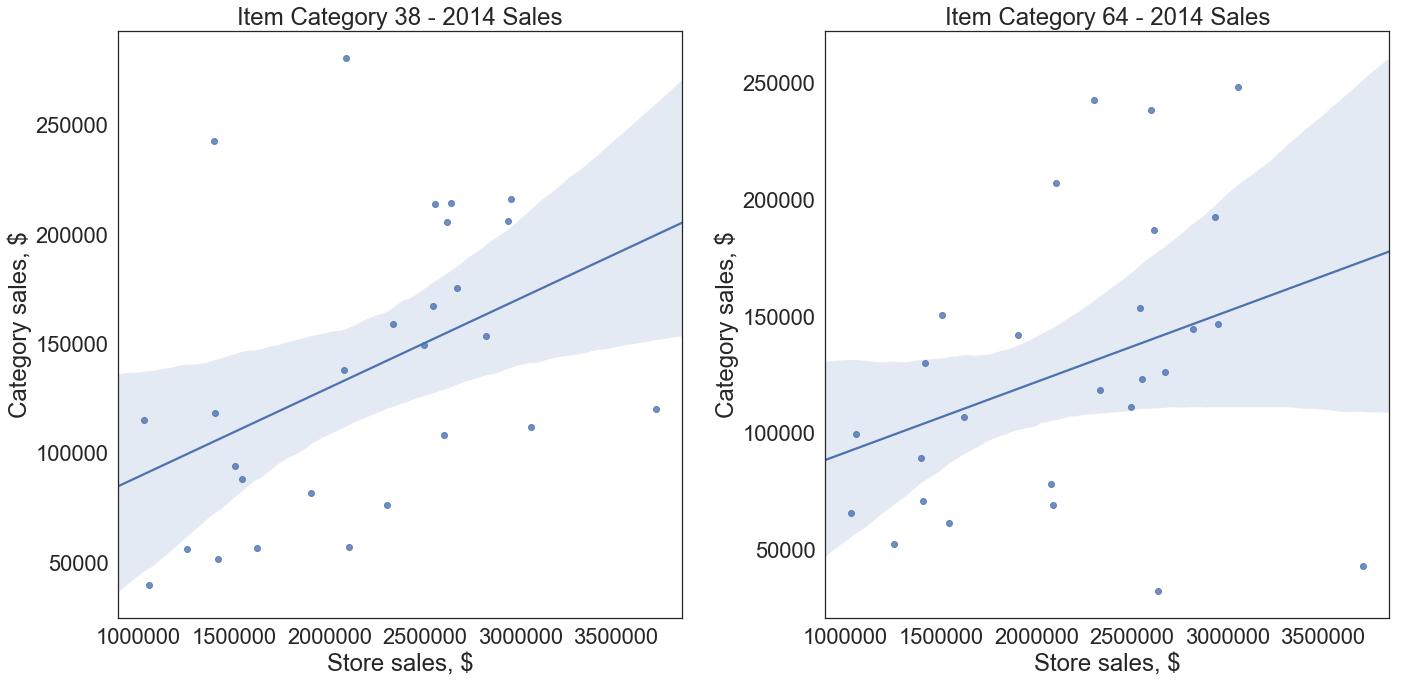

In [116]:
#individual scatter plots for each of the 5 top categories 

plt.subplot(1,3,1)
sns.regplot(x=store_sales.sales,y=store_sales.item_cat_35_sales)
plt.title('Item Category 35 - 2014 Sales')
plt.xlabel('Store sales, $')
plt.ylabel('Category sales, $')

plt.subplot(1,3,2)
sns.regplot(x=store_sales.sales,y=store_sales.item_cat_2_sales)
plt.title('Item Category 2 - 2014 Sales')
plt.xlabel('Store sales, $')
plt.ylabel('Category sales, $')

plt.subplot(1,3,3)
sns.regplot(x=store_sales.sales,y=store_sales.item_cat_6_sales)
plt.title('Item Category 6 - 2014 Sales')
plt.xlabel('Store sales, $')
plt.ylabel('Category sales, $')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.regplot(x=store_sales.sales,y=store_sales.item_cat_38_sales)
plt.title('Item Category 38 - 2014 Sales')
plt.xlabel('Store sales, $')
plt.ylabel('Category sales, $')

plt.subplot(1,2,2)
sns.regplot(x=store_sales.sales,y=store_sales.item_cat_64_sales)
plt.title('Item Category 64 - 2014 Sales')
plt.xlabel('Store sales, $')
plt.ylabel('Category sales, $')
plt.tight_layout()
plt.show()

### Question 2 Conclusion: 
Minus a few outliers, there is a strong correlation between store sales and category sales. Knowing which stores a category is sold in may help to predict the category sales. 

## Question 3: Store Unique Item Count - Will stores with more unique items have higher revenues? 

Before we begin analyzing, let's create a dataframe that consists of yearly sales by store and add a column that provides the unique item count by store. 

In [117]:
###add unique item count to store_sales dataframe 
store_sales = low_season.groupby('shop_id').sum()['sales']
store_sales = store_sales.to_frame()

store_sales['unique_item_count']=np.nan

store_item_sales = low_season.groupby(['shop_id','item_id']).sum()

for i in store_sales.index:
    store_sales.loc[i].unique_item_count = len(store_item_sales.loc[i].index)
    
store_sales.head()    

,sales,unique_item_count
shop_id,,
2,1252242.62,407.0
4,1541442.69,521.0
5,1619563.68,570.0
7,2553608.41,711.0
14,1413913.30,485.0


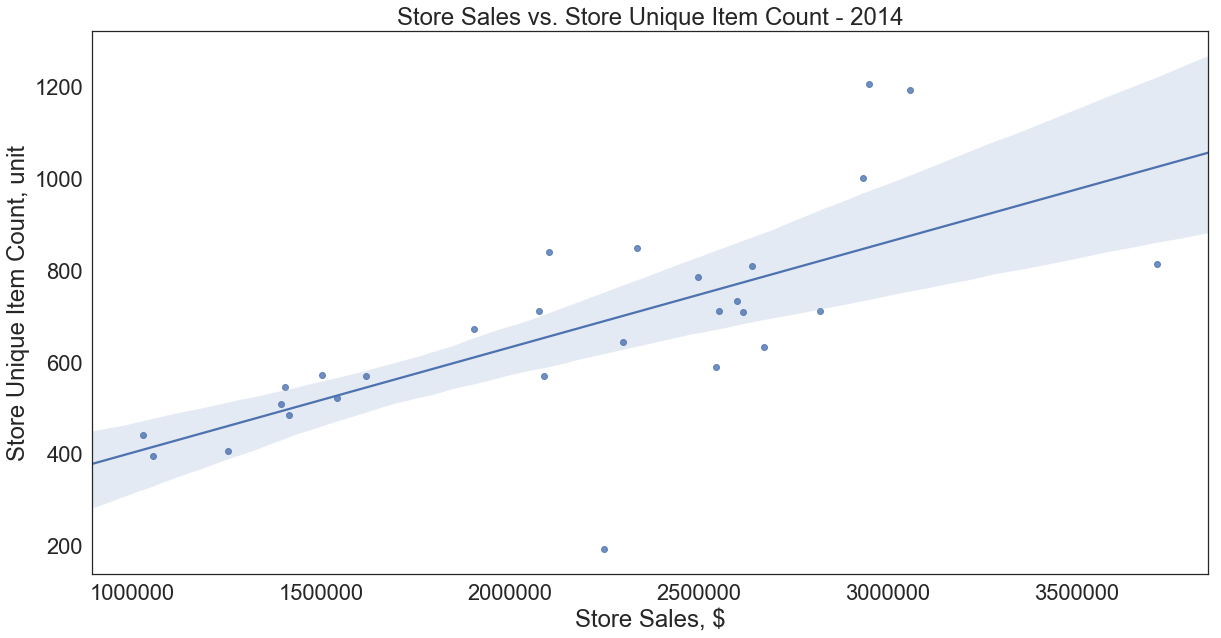

In [118]:
sns.regplot(x=store_sales.sales,y=store_sales.unique_item_count)
plt.title('Store Sales vs. Store Unique Item Count - 2014')
plt.ylabel('Store Unique Item Count, unit')
plt.xlabel('Store Sales, $')
plt.show()

In [119]:
print(np.corrcoef(x=store_sales.sales,y=store_sales.unique_item_count))

[[1.        0.6958557]
 [0.6958557 1.       ]]


### Question 3 Conclusion:
As you can see, minus two outliers, their is a strong correlation between store unique item count and stores sales. In conclusion, you are able to predict store sals by the amount of items it carries. 

## Question 4: Item Price - As the an item's price moves away from its mean, will unit sales fall? 

First, lets create a new dataframe from low_season, setting item_id as the index. From there, we will add a column named price_nomalization, that will normalize the item's price. The reason we are nomalizing prices is because the price for items flunctate throughout the year. I believe that price fluctuation affects sales and normalizing the price will allow us to quantify the affects. The formula for normalizing is normal price = (price - item price mean)/(item price max - item price min)

In [120]:
item_price = low_season.set_index('item_id')

item_price['price_normalization'] = np.nan
item_price['avg'] = np.nan
item_price['max_min'] = np.nan

for i in item_price.index.unique(): 
    avg = item_price.loc[i, 'item_price'].mean()
    max_min = item_price.loc[i, 'item_price'].max() - item_price.loc[i, 'item_price'].min()
    item_price.loc[i, 'avg'] = avg 
    item_price.loc[i,'max_min'] = max_min
    
#remove max_min == 0 
item_price = item_price[np.logical_not(item_price.max_min==0)]
#calculate price_normalization and add into column 
item_price.price_normalization = item_price.item_price - item_price.avg 
item_price.price_normalization = item_price.price_normalization / item_price.max_min
item_price.head()

,date,date_block_num,shop_id,item_price,item_cnt_day,item_name,item_category_id,year,sales,price_normalization,avg,max_min
item_id,,,,,,,,,,,,
2920,2014-01-11,12,53,599.0,1.0,Disney. LEGO Пираты Карибского моря (Essential...,21,2014,599.0,0.396092,527.584694,180.3
2920,2014-01-04,12,56,599.0,1.0,Disney. LEGO Пираты Карибского моря (Essential...,21,2014,599.0,0.396092,527.584694,180.3
2920,2014-01-11,12,56,599.0,1.0,Disney. LEGO Пираты Карибского моря (Essential...,21,2014,599.0,0.396092,527.584694,180.3
2920,2014-01-03,12,29,599.0,1.0,Disney. LEGO Пираты Карибского моря (Essential...,21,2014,599.0,0.396092,527.584694,180.3
2920,2014-01-25,12,50,599.0,1.0,Disney. LEGO Пираты Карибского моря (Essential...,21,2014,599.0,0.396092,527.584694,180.3


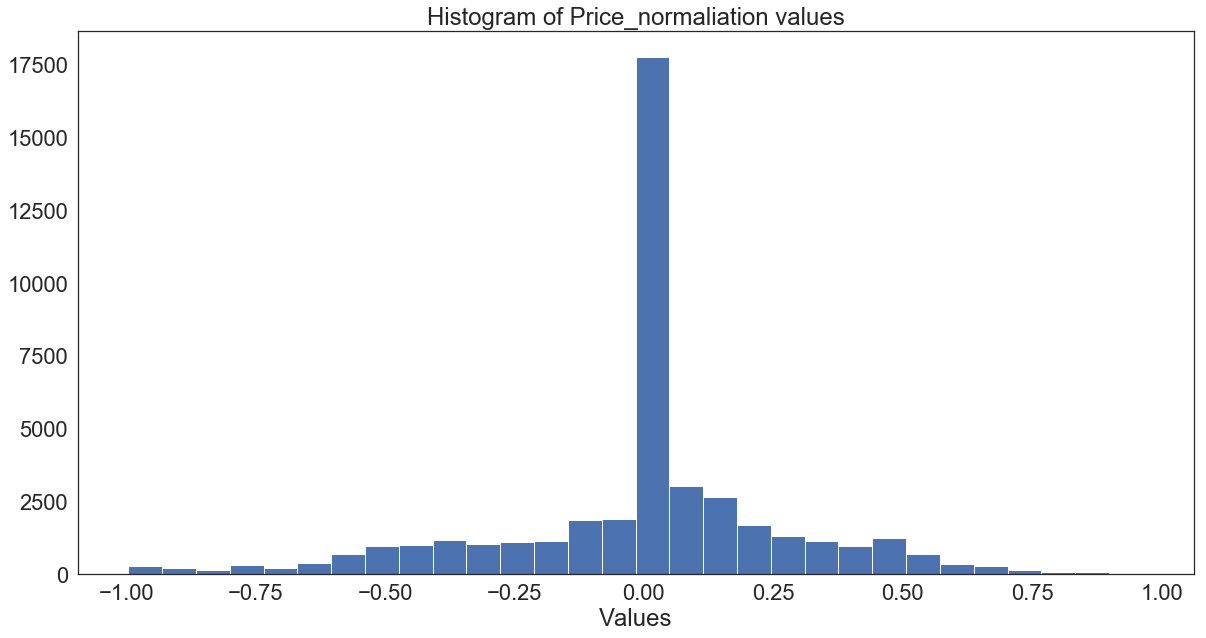

Price normalization mean is 8.508266990990107e-16
Price normalization std is 0.28609256898562574


In [126]:
#histogram of price_normalization column 
plt.hist(item_price.price_normalization, bins=30)
plt.title('Histogram of Price_normaliation values')
plt.xlabel('Values')
plt.show()

print('Price normalization mean is {}'.format(item_price.price_normalization.mean()))
print('Price normalization std is {}'.format(item_price.price_normalization.std()))

In [122]:
#create new dataframe of unit totals indexed by sub-categories of price_normalization values
index = pd.Index(['-1_to_-0.75','-0.75_to_-0.50',
                  '-0.50_to_-0.25','-0.25_to_0.00','0.00_to_0.25',
                  '0.25_to_0.50','0.50_to_0.75','0.75_to_1.00'])
unit_variation = pd.Series(index=index)
unit_variation.iloc[0] = item_price.query('price_normalization <= -0.75').sum()['item_cnt_day']
unit_variation.iloc[1] = item_price.query('-0.75 < price_normalization <= -0.5').sum()['item_cnt_day']
unit_variation.iloc[2] = item_price.query('-0.5 < price_normalization <= -0.25').sum()['item_cnt_day']
unit_variation.iloc[3] = item_price.query('-0.25 < price_normalization <= 0.0').sum()['item_cnt_day']
unit_variation.iloc[4] = item_price.query('0.0 < price_normalization <= 0.25').sum()['item_cnt_day']
unit_variation.iloc[5] = item_price.query('0.25 < price_normalization <= 0.50').sum()['item_cnt_day']
unit_variation.iloc[6] = item_price.query('0.50 < price_normalization <= 0.75').sum()['item_cnt_day']
unit_variation.iloc[7] = item_price.query('0.75 < price_normalization').sum()['item_cnt_day']
unit_variation

-1_to_-0.75        1332.0
-0.75_to_-0.50     2274.0
-0.50_to_-0.25     4335.0
-0.25_to_0.00      6187.0
0.00_to_0.25      28283.0
0.25_to_0.50       4928.0
0.50_to_0.75       1601.0
0.75_to_1.00        214.0
dtype: float64

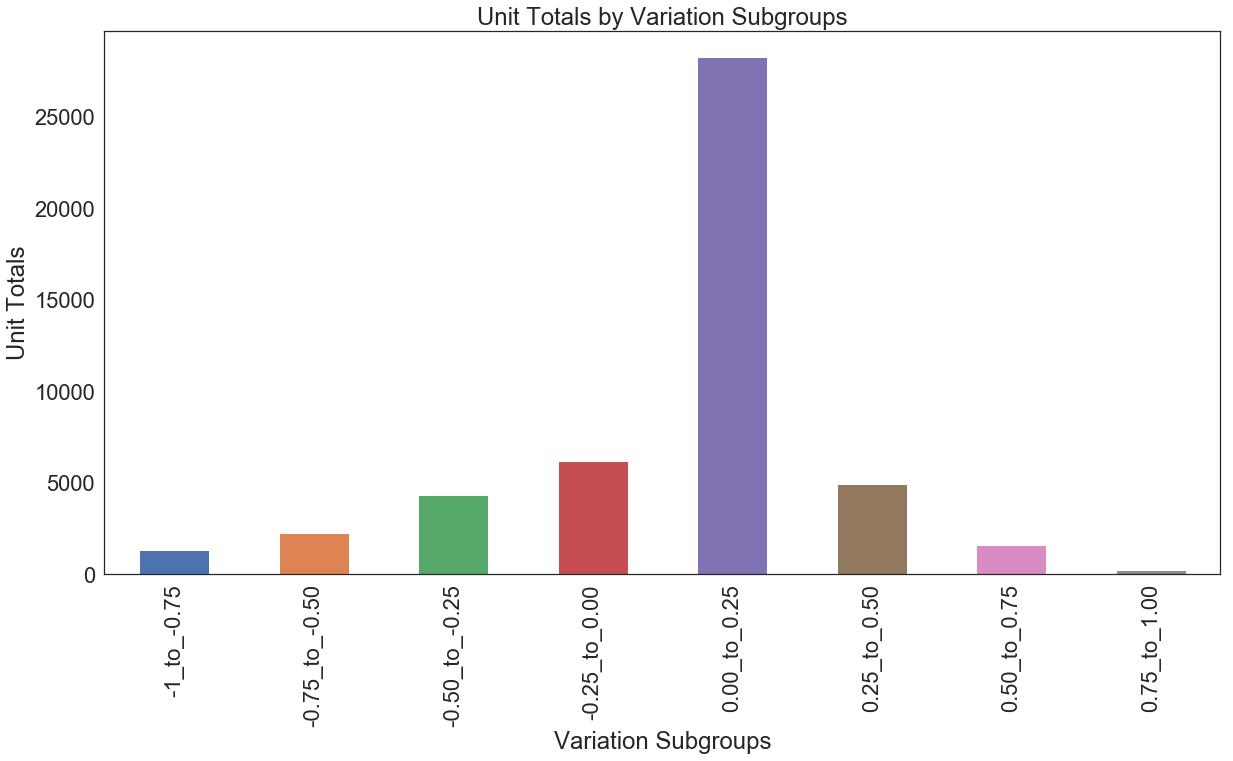

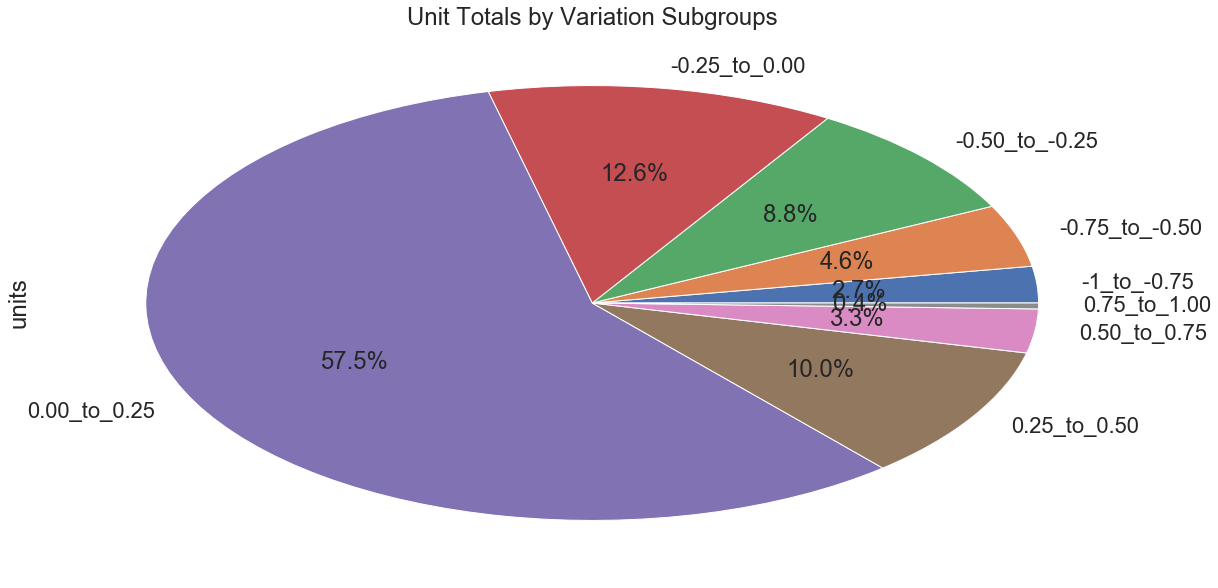

In [127]:
#plot unit totals 
unit_variation.plot(kind='bar')
plt.title('Unit Totals by Variation Subgroups')
plt.ylabel('Unit Totals')
plt.xlabel('Variation Subgroups')
plt.show()

unit_variation.plot(kind='pie',autopct='%1.1f%%')
plt.title('Unit Totals by Variation Subgroups')
plt.ylabel('units')
plt.show()

In [128]:
#create new dataframe of sale totals indexed by sub-categories of price_normalization values
sales_variation = pd.Series(index=index)
sales_variation.iloc[0] = item_price.query('price_normalization <= -0.75').sum()['sales']
sales_variation.iloc[1] = item_price.query('-0.75 < price_normalization <= -0.5').sum()['sales']
sales_variation.iloc[2] = item_price.query('-0.5 < price_normalization <= -0.25').sum()['sales']
sales_variation.iloc[3] = item_price.query('-0.25 < price_normalization <= 0.0').sum()['sales']
sales_variation.iloc[4] = item_price.query('0.0 < price_normalization <= 0.25').sum()['sales']
sales_variation.iloc[5] = item_price.query('0.25 < price_normalization <= 0.50').sum()['sales']
sales_variation.iloc[6] = item_price.query('0.50 < price_normalization <= 0.75').sum()['sales']
sales_variation.iloc[7] = item_price.query('0.75 < price_normalization').sum()['sales']
sales_variation

-1_to_-0.75        1149607.51
-0.75_to_-0.50     1761374.26
-0.50_to_-0.25     3796449.36
-0.25_to_0.00      6960633.43
0.00_to_0.25      29259404.08
0.25_to_0.50       5233203.61
0.50_to_0.75       1653372.80
0.75_to_1.00        369419.70
dtype: float64

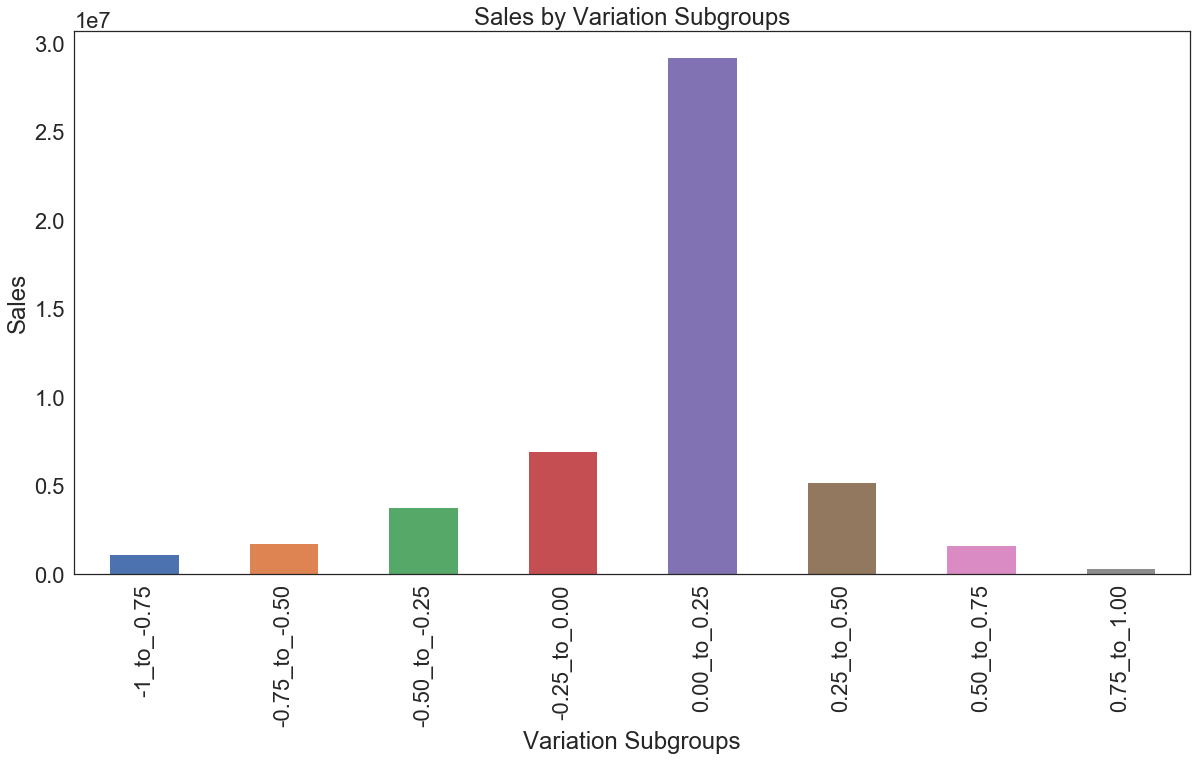

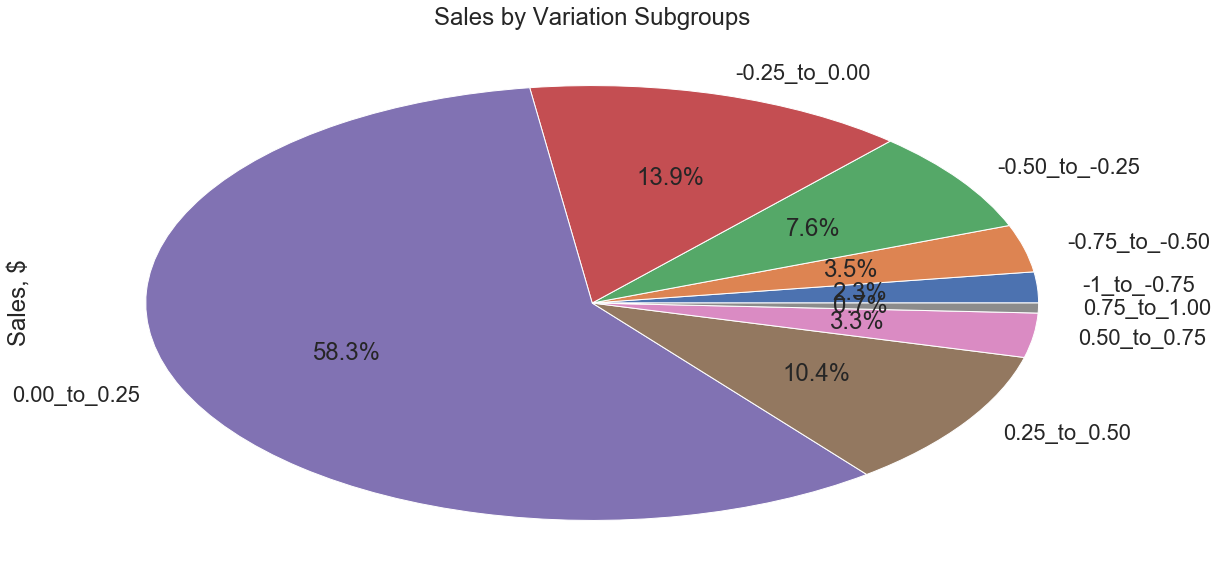

In [129]:
sales_variation.plot(kind='bar')
plt.title('Sales by Variation Subgroups')
plt.ylabel('Sales')
plt.xlabel('Variation Subgroups')
plt.show()
sales_variation.plot(kind='pie',autopct='%1.1f%%')
plt.title('Sales by Variation Subgroups')
plt.ylabel('Sales, $')
plt.show()

### Question 4 Conclusion:

Its clear that price variation affects sales. As an item's price moves away from its mean, the less items it will sell. However, please note that there are more cases where items are being sold within the 0.00-0.25 subgroup, than in any other sub_group. 

## Question 5: Can you predict item unit sales by category sales?  

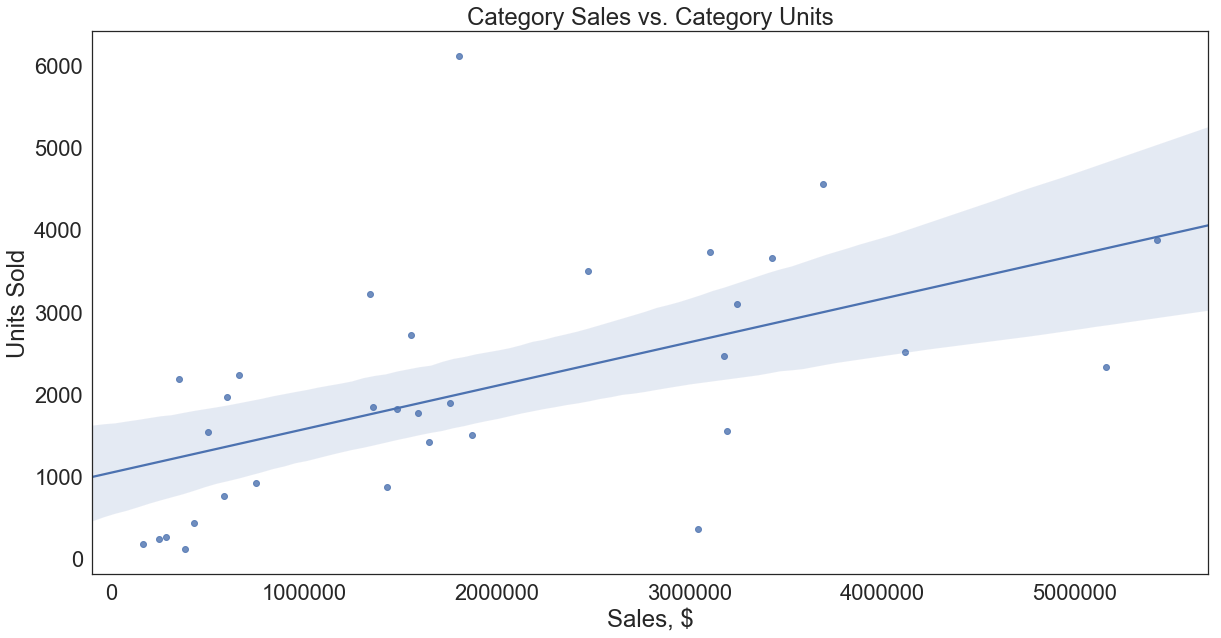

In [130]:
#create two series, one for total unit sales by categories, and another for total sales by category
category_unit_sales = low_season.groupby('item_category_id')['item_cnt_day'].sum()
category_sales = low_season.groupby('item_category_id')['sales'].sum()

#create scatter plot to analyze correlation between two series 
sns.regplot(x=category_sales,y=category_unit_sales)
plt.title('Category Sales vs. Category Units')
plt.xlabel('Sales, $')
plt.ylabel('Units Sold')
plt.show()

In [131]:
print(np.corrcoef(x=category_sales,y=category_unit_sales))

[[1.         0.54707071]
 [0.54707071 1.        ]]


### Question 5 Conclusion: 
In conclusion, their is a strong correlation between category sales and category unit sales, minus a few outliers. 

## Futher Research 

After reviewing how 5 attributes may affect item and store sales, I would proposed further research on the following:

- Time: see how sales may vary day to day. There may be days where sales are higher than usual (ex. black friday)
- Shop item prices: Are there stores that specialize in the sell of 'expensive' items, i.e. items that may cost over 500 dollars? If so, how does that affect sales?
- Item sales within stores: will an item sell more in a store that sells a large variaty of items than in a store with a small variety of items?
- Further analyzation within price variation: are there certain times throughout the year where prices vary more? If so, how does that affect sales? Analyze the amount of unique items within each variation subgroup. Analyze random items to see how price variation affects their sales. 